# 📘 `day3_4_parking_path_control.ipynb` Structure

# 🚗 Day 3: Trajectory Planner
- generate_bezier_curve()
- Plot test

# 🎮 Day 4: Vehicle Controller
- calculate_vehicle_controls()
- Print instructions from Bezier path

	•	helpers → generate_path_for_strategy → build full_path → curve_points → auto‑align → animation → save ✅

	•	Helpers → generate_path_for_strategy → plan_and_align → render.


# Cell 1 — Imports & Parameters

In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Scenario params (match your Streamlit defaults) ---
spot_length = 6.2
spot_width  = 3.0
car_length  = spot_length * 0.60   # same ratio you used
car_width   = spot_width  * 0.55
distance_to_spot = 2.0
spot_origin = np.array([15.0, 3.0])   # not used for local path template here

# Bicycle model wheelbase (approx); you can refine later
wheelbase = max(2.4, 0.55 * car_length)  # meters

# Cell 2 — Minimal helpers (same logic as in app.py)

In [2]:
def generate_bezier_curve(p0, p1, p2, n=40):
    t = np.linspace(0, 1, n).reshape(-1, 1)
    p0, p1, p2 = map(np.array, (p0, p1, p2))
    return (1 - t)**2 * p0 + 2*(1 - t)*t*p1 + t**2 * p2  # (n,2)

def make_arc(start_xy, mid_offset, end_offset, n=40):
    sx, sy = start_xy
    p0 = (sx, sy)
    p1 = (sx + mid_offset[0], sy + mid_offset[1])
    p2 = (sx + end_offset[0], sy + end_offset[1])
    return generate_bezier_curve(p0, p1, p2, n)

def straight_segment(start_xy, length, heading_deg, n=15):
    sx, sy = start_xy
    rad = np.radians(heading_deg)
    ex, ey = sx + length*np.cos(rad), sy + length*np.sin(rad)
    return np.column_stack([np.linspace(sx, ex, n),
                            np.linspace(sy, ey, n)])

def concat_paths(*paths):
    out = []
    for k, p in enumerate(paths):
        p = np.asarray(p)
        if k > 0 and len(out) and len(p):
            out.extend(p[1:])   # avoid duplicate seam point
        else:
            out.extend(p)
    return np.array(out)

def headings_from_path(path_xy):
    # returns yaw in radians
    d = np.diff(path_xy, axis=0, prepend=path_xy[:1])
    return np.arctan2(d[:, 1], d[:, 0])

# Cell 3 — Forward‑Perpendicular path (same shape as the app)

In [3]:
def forward_perpendicular_path(car_length, car_width, spot_length, spot_width, distance_to_spot,
                               nA=45, nS=12, nB=28):
    def clamp(v, lo, hi):
        return max(lo, min(hi, v))

    x_swing = clamp(0.3 * spot_width, 0.5, 1.0)
    approach_y = clamp(0.4 * distance_to_spot + 0.3 * spot_length,
                       1.0, distance_to_spot + 0.5 * spot_length)

    pathA = make_arc((0.0, 0.0), (+x_swing, 0.55 * approach_y),
                     (+0.25 * x_swing, approach_y), n=nA)
    pathS = straight_segment(tuple(pathA[-1]), length=0.3, heading_deg=85, n=nS)
    pathB = make_arc(tuple(pathS[-1]), (-0.45 * x_swing, 0.25 * spot_length),
                     (-0.18 * x_swing, 0.38 * spot_length), n=nB)

    return concat_paths(pathA, pathS, pathB)  # (N,2)

# Cell 4 — Curvature, steering, and speed profile

In [4]:
def path_curvature(path_xy):
    """
    Approximate signed curvature kappa along the polyline.
    kappa = heading_change / arc_length between successive points.
    """
    # tiny epsilon to avoid division by zero
    eps = 1e-6
    # arc lengths between points
    dxy = np.diff(path_xy, axis=0, prepend=path_xy[:1])
    ds = np.hypot(dxy[:,0], dxy[:,1]) + eps

    # heading and its discrete derivative
    yaw = headings_from_path(path_xy)              # radians
    dyaw = np.diff(yaw, prepend=yaw[:1])

    # wrap dyaw to [-pi, pi]
    dyaw = (dyaw + np.pi) % (2*np.pi) - np.pi

    # curvature ~ delta_heading / distance
    kappa = dyaw / ds
    return kappa, yaw, ds

def steering_from_curvature(kappa, wheelbase):
    """
    Bicycle model: delta = atan(L * kappa)
    Returns steering angles (radians).
    """
    return np.arctan(wheelbase * kappa)

def simple_speed_profile(ds, v_in=2.0, v_mid=1.3, v_final=0.6):
    """
    Piecewise-constant-ish speed along the path:
    - faster at the beginning, slower near the end.
    """
    N = len(ds)
    s = np.cumsum(ds)
    s_norm = s / (s[-1] if s[-1] > 0 else 1.0)
    # smooth blend between v_in -> v_mid -> v_final
    v = ( (1 - s_norm) * v_in
        + (np.clip(1 - np.abs(s_norm-0.5)*2, 0, 1)) * (v_mid - v_final)
        + s_norm * v_final )
    return v

# Cell 5 — Generate control points + save to CSV

In [5]:
# 1) Path
path_xy = forward_perpendicular_path(
    car_length=car_length, car_width=car_width,
    spot_length=spot_length, spot_width=spot_width,
    distance_to_spot=distance_to_spot,
    nA=60, nS=20, nB=40
)

# 2) Curvature, yaw, arc length
kappa, yaw_rad, ds = path_curvature(path_xy)

# 3) Steering (radians → degrees)
steer_rad = steering_from_curvature(kappa, wheelbase)
steer_deg = np.degrees(steer_rad)
yaw_deg   = np.degrees(yaw_rad)

# 4) Speed profile
speed_mps = simple_speed_profile(ds, v_in=2.0, v_mid=1.3, v_final=0.6)

# 5) Pack control points
df = pd.DataFrame({
    "x": path_xy[:,0],
    "y": path_xy[:,1],
    "yaw_deg": yaw_deg,
    "curvature": kappa,
    "steer_deg": steer_deg,
    "speed_mps": speed_mps
})

# 6) Save
!mkdir -p data
csv_path = "data/control_points_forward.csv"
df.to_csv(csv_path, index=False)
csv_path

'data/control_points_forward.csv'

# Cell 6 — Quick visual checks (optional but recommended)

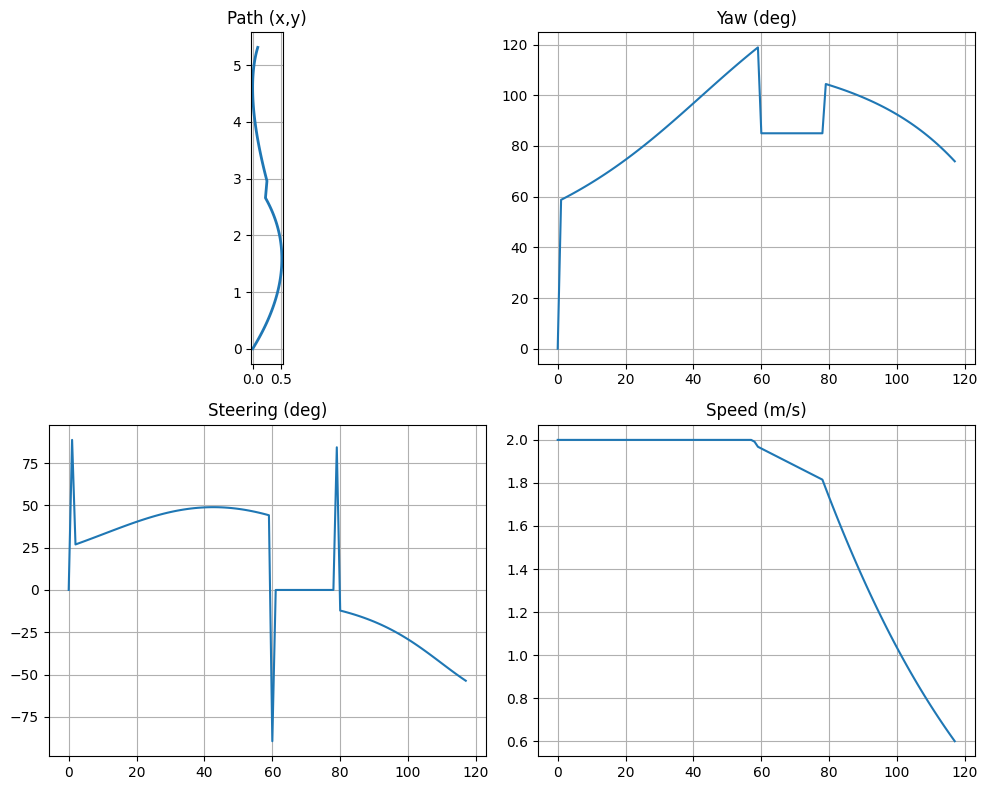

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.ravel()

# Path
axs[0].plot(df["x"], df["y"], lw=2)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title("Path (x,y)")
axs[0].grid(True)

# Yaw
axs[1].plot(np.arange(len(df)), df["yaw_deg"])
axs[1].set_title("Yaw (deg)")
axs[1].grid(True)

# Steering
axs[2].plot(np.arange(len(df)), df["steer_deg"])
axs[2].set_title("Steering (deg)")
axs[2].grid(True)

# Speed
axs[3].plot(np.arange(len(df)), df["speed_mps"])
axs[3].set_title("Speed (m/s)")
axs[3].grid(True)

plt.tight_layout()
plt.show()

In [16]:
%%writefile /content/final_project_AVP/self_parking_ai/app.py
# app.py — Self‑Parking AI Simulator (Forward Perpendicular MVP)

import streamlit as st
st.set_page_config(page_title="Self‑Parking AI Simulator", layout="centered")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

st.title("🚗 Self‑Parking AI Simulator — Forward Perpendicular (MVP)")

# ---- Sidebar inputs ----
with st.sidebar:
    st.header("Inputs")
    spot_length = st.number_input("Spot length (m)", 3.5, 8.0, 6.2, 0.1)
    spot_width  = st.number_input("Spot width (m)",  2.2, 4.0, 3.0, 0.1)

    size_preset = st.selectbox("Car size preset", ["Relative: 60% × 55%", "Manual"])
    if size_preset == "Relative: 60% × 55%":
        car_length = spot_length * 0.60
        car_width  = spot_width  * 0.55
        st.caption(f"Car L×W = {car_length:.2f} × {car_width:.2f} m")
    else:
        car_length = st.number_input("Car length (m)", 3.0, 5.6, 4.5, 0.1)
        car_width  = st.number_input("Car width (m)",  1.5, 2.2, 1.8, 0.05)

    distance_to_spot = st.slider("Distance to spot (m)", 0.5, 6.0, 2.0, 0.1)
    inset = st.slider("Rear bumper inset (m)", 0.05, 0.5, 0.10, 0.01)

    spot_x = st.number_input("Spot origin X (m)", -10.0, 30.0, 15.0, 0.1)
    spot_y = st.number_input("Spot origin Y (m)", -10.0, 30.0,  3.0, 0.1)

    run_button = st.button("Plan Path")

spot_origin = np.array([spot_x, spot_y], dtype=float)

# ---- Helpers ----
def generate_bezier_curve(p0, p1, p2, n=40):
    t = np.linspace(0, 1, n).reshape(-1, 1)
    p0, p1, p2 = map(np.array, (p0, p1, p2))
    return (1 - t)**2 * p0 + 2*(1 - t)*t*p1 + t**2 * p2

def make_arc(start_xy, mid_offset, end_offset, n=40):
    sx, sy = start_xy
    p0 = (sx, sy)
    p1 = (sx + mid_offset[0], sy + mid_offset[1])
    p2 = (sx + end_offset[0], sy + end_offset[1])
    return generate_bezier_curve(p0, p1, p2, n)

def straight_segment(start_xy, length, heading_deg, n=15):
    sx, sy = start_xy
    rad = np.radians(heading_deg)
    ex, ey = sx + length*np.cos(rad), sy + length*np.sin(rad)
    xs = np.linspace(sx, ex, n)
    ys = np.linspace(sy, ey, n)
    return np.column_stack([xs, ys])

def concat_paths(*paths):
    out = []
    for k, p in enumerate(paths):
        p = np.asarray(p)
        if k > 0 and len(out) and len(p):
            out.extend(p[1:])
        else:
            out.extend(p)
    return np.array(out, dtype=float)

def heading_at(path_xy, i):
    p = np.asarray(path_xy)
    i = int(np.clip(i, 1, len(p)-1))
    dx = p[i, 0] - p[i-1, 0]
    dy = p[i, 1] - p[i-1, 1]
    return np.degrees(np.arctan2(dy, dx))

def rear_bumper_center(center_xy, yaw_deg, car_length):
    rad = np.radians(yaw_deg)
    return np.array(center_xy) - 0.5 * car_length * np.array([np.cos(rad), np.sin(rad)])

def rotate_path_about_point(points, center_xy, delta_deg):
    rad = np.radians(delta_deg)
    R = np.array([[np.cos(rad), -np.sin(rad)],
                  [np.sin(rad),  np.cos(rad)]])
    P = np.asarray(points) - center_xy
    P = P @ R.T
    return P + center_xy

def compute_rear_target(spot_origin, spot_width, spot_length, car_length,
                        inset=0.10, enter_from='bottom'):
    x = float(spot_origin[0]) + float(spot_width) / 2.0
    if enter_from == 'bottom':
        y = float(spot_origin[1]) + inset
    elif enter_from == 'top':
        y = float(spot_origin[1]) + float(spot_length) - inset
    else:
        raise ValueError("enter_from must be 'bottom' or 'top'")
    return np.array([x, y], dtype=float)

def wrap180(a_deg):  # [-180, 180)
    return ((a_deg + 180.0) % 360.0) - 180.0

# ---- Forward path (template) ----
def generate_path_for_strategy_forward(car_length, car_width,
                                       spot_length, spot_width,
                                       distance_to_spot,
                                       nA=60, nS=20, nB=40):
    def clamp(v, lo, hi): return max(lo, min(hi, v))
    x_swing = clamp(0.3 * spot_width, 0.5, 1.0)
    approach_y = clamp(0.4 * distance_to_spot + 0.3 * spot_length,
                       1.0, distance_to_spot + 0.5 * spot_length)
    pathA = make_arc((0.0, 0.0),
                     (+x_swing, 0.55 * approach_y),
                     (+0.25 * x_swing, approach_y),
                     n=nA)
    pathS = straight_segment(tuple(pathA[-1]),
                             length=0.3,
                             heading_deg=85,
                             n=nS)
    pathB = make_arc(tuple(pathS[-1]),
                     (-0.45 * x_swing, 0.25 * spot_length),
                     (-0.18 * x_swing, 0.38 * spot_length),
                     n=nB)
    return concat_paths(pathA, pathS, pathB)

# ---- Plan + align to bay ----
def plan_and_align_forward(car_length, car_width,
                           spot_length, spot_width,
                           spot_origin,
                           distance_to_spot=2.0,
                           inset=0.10):
    curve_points = generate_path_for_strategy_forward(
        car_length, car_width, spot_length, spot_width, distance_to_spot
    )
    spot_mid_y = float(spot_origin[1]) + float(spot_length)/2.0
    entry_side = 'bottom' if curve_points[0, 1] < spot_mid_y else 'top'
    rear_target = compute_rear_target(spot_origin, spot_width, spot_length,
                                      car_length, inset=inset, enter_from=entry_side)
    end_center = curve_points[-1]
    yaw_end = heading_at(curve_points, len(curve_points) - 1)
    rear_now = rear_bumper_center(end_center, yaw_end, car_length)
    yaw_target = 90.0
    delta_yaw = wrap180(yaw_target - yaw_end)
    curve_points = rotate_path_about_point(curve_points, rear_now, delta_yaw)
    end_center_rot = curve_points[-1]
    rear_now_rot = rear_bumper_center(end_center_rot, yaw_target, car_length)
    delta = rear_target - rear_now_rot
    curve_points = curve_points + delta
    return {
        "curve_points": curve_points,
        "rear_target": rear_target,
        "yaw_target": float(yaw_target),
        "entry_side": entry_side,
        "rear_bumper_after": rear_target.copy()
    }

# ---- Run button ----
if run_button:
    plan = plan_and_align_forward(
        car_length=car_length,
        car_width=car_width,
        spot_length=spot_length,
        spot_width=spot_width,
        spot_origin=spot_origin,
        distance_to_spot=distance_to_spot,
        inset=inset
    )
    curve_points = plan["curve_points"]

    fig, ax = plt.subplots(figsize=(6, 8))
    ax.grid(True, alpha=0.35)
    spot_rect = patches.Rectangle(
        (spot_origin[0], spot_origin[1]),
        spot_width, spot_length,
        linewidth=1.8, edgecolor='green', facecolor='none',
        linestyle='--', label='Parking Spot', zorder=5
    )
    ax.add_patch(spot_rect)
    rear_target = plan["rear_target"]
    ax.scatter(rear_target[0], rear_target[1], s=80, marker='x', label='Rear Target')
    rb = plan["rear_bumper_after"]
    ax.scatter(rb[0], rb[1], s=60, marker='+', label='Rear Bumper (after align)')
    ax.plot(curve_points[:, 0], curve_points[:, 1], lw=2.2, label='Path')

    xs = curve_points[:, 0]; ys = curve_points[:, 1]
    sx0, sy0 = float(spot_origin[0]), float(spot_origin[1])
    sx1, sy1 = sx0 + float(spot_width), sy0 + float(spot_length)
    pad = 0.8
    ax.set_xlim(min(xs.min(), sx0, sx1) - pad, max(xs.max(), sx0, sx1) + pad)
    ax.set_ylim(min(ys.min(), sy0, sy1) - pad, max(ys.max(), sy0, sy1) + pad)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper left')

    st.pyplot(fig)
    st.subheader("Plan Summary")
    st.write(f"- Entry side (auto): **{plan['entry_side']}**")
    st.write(f"- Final heading: **{plan['yaw_target']:.1f}°**")
    st.write(f"- Car (L×W): **{car_length:.2f} × {car_width:.2f} m**")
    st.write(f"- Spot (L×W): **{spot_length:.2f} × {spot_width:.2f} m**")
    st.write(f"- Inset: **{inset:.2f} m**, Distance: **{distance_to_spot:.2f} m**")
else:
    st.info("Set inputs in the sidebar and click **Plan Path**.")

Writing /content/final_project_AVP/self_parking_ai/app.py


In [17]:
%cd /content/final_project_AVP/self_parking_ai
!ls

/content/final_project_AVP/self_parking_ai
app.py


Entry side: bottom | Fits W/L: False True
Saved GIF: parking_animation.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

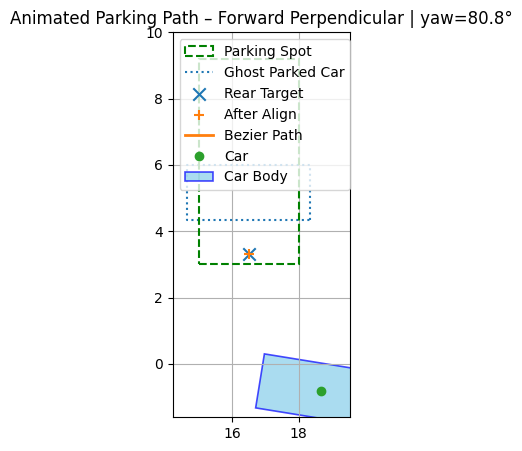

In [4]:
# # ONE-CELL MULTI-SEGMENT PARK, AUTO-ALIGN, ROTATE, SAVE GIF/MP4

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.animation import FuncAnimation, PillowWriter
# from matplotlib.transforms import Affine2D
# from IPython.display import HTML
# from google.colab import files

# # ===== Scene & vehicle setup (units: meters) =====
# spot_length = 6.2
# spot_width  = 3.0
# car_length = spot_length * 0.6
# car_width  = spot_width * 0.55
# spot_origin = np.array([15.0, 3.0])
# # (x, y) of the bay’s bottom-left corner in world coordinates
# use_reverse = False
# # Choose strategy from a simple toggle:
# # - If use_reverse is True  -> "Reverse Parallel"
# # - If use_reverse is False -> "Forward Perpendicular"
# strategy = "Reverse Parallel" if use_reverse else "Forward Perpendicular"

# # ==================== Path helpers ====================
# def concat_paths(*paths):
#   #*paths: variadic parameter in Python.
#   # It means the function can take any number of arguments.可变参数，表示可以传入多个“路径段”
#     """
#     Join multiple path segments end-to-end into a single continuous path.
#     Each path is an array of (x, y) points. We skip the first point of
#     subsequent segments to avoid duplicating the join point.
#     这个循环会把多个路径段拼成一个连续的路径：•	第一个路径段保留所有点；•	后面的路径段跳过第一个点，避免重复连接点；•	最后返回一个 NumPy 数组格式的完整路径。
#     """
#     out = []
#     for k, p in enumerate(paths):
#         p = np.asarray(p)
#         if k > 0 and len(out) and len(p):
# #“If this is not the first segment, and we already have some points collected,
# # and this segment has points too…” “如果当前不是第一个路径段，并且已经有拼好的路径，并且当前路径段也不为空…”
# # k > 0 → 判断是不是第一个路径段（k=0 是第一个，k>0 说明是后面的路径段）
# #len(out) → 判断已经拼好的路径 out 是否有内容（长度不为 0）
# #len(p) → 判断当前路径段 p 是否有点（长度不为 0）
#             out.extend(p[1:])   # skip duplicate seam point → smooth connection
#         else:
#             out.extend(p)
#     return np.array(out)
# # enumerate(paths) → 把 paths（如 (pathA, pathB, pathC)）变成一个同时返回索引 k 和对应值 p 的迭代器
# # p → The actual path segment (e.g., array of (x, y) points).
# # p = np.asarray(p) #p → The current path segment we’re working with.
# # np.asarray(p) → Converts p into a NumPy array if it’s not already one,
# # so we can be sure we can use NumPy operations later.
# #	out → The list that collects all path points from all segments.
# # When you call concat_paths(path0, pathA, pathB), inside the function paths becomes a tuple: (path0, pathA, pathB)
# # A path segment is a sequence of points sampled along a straight line or a Bezier arc — i.e. an N×2 array of (x, y) points
# # Examples of segments:
# # •	straight_segment(...) returns something like: [[0. , 0. ],[0.5, 0. ],[1.0, 0. ], ...]        # N×2
# # •	make_arc(...) returns a curved sequence: [[1.00, 0.00],[0.98, 0.10],[0.92, 0.22], ...]      # N×2 along a curve

# # This function generates n points along a quadratic Bézier curve defined by three points:p0, p1, p2
# def generate_bezier_curve(p0, p1, p2, n=40):
#     t = np.linspace(0, 1, n).reshape(-1, 1)     #creates n evenly spaced numbers between 0 and 1. #.reshape(-1, 1) makes t into a column vector so broadcasting works with (x, y) pairs
#     p0, p1, p2 = map(np.array, (p0, p1, p2))
#     return (1 - t)**2 * p0 + 2*(1 - t)*t*p1 + t**2 * p2
#     # Return an (n, 2) NumPy array of (x, y) coordinates along the curve 返回 (n, 2) 的数组，每一行是曲线上一个 (x, y) 坐标

# # This is a convenience wrapper to make a curved segment (arc) relative to a starting point 辅助函数，用来根据起点生成一段弯曲路径（弧线)
# def make_arc(start_xy, mid_offset, end_offset, n=40):
#     sx, sy = start_xy
#     p0 = (sx, sy)
#     p1 = (sx + mid_offset[0], sy + mid_offset[1])
#     p2 = (sx + end_offset[0], sy + end_offset[1])
#     return generate_bezier_curve(p0, p1, p2, n)

# # Generates n evenly spaced points along a straight line segment
# def straight_segment(start_xy, length, heading_deg, n=15):
#     sx, sy = start_xy
#     rad = np.radians(heading_deg) #Convert heading from degrees to radians:
#     ex, ey = sx + length*np.cos(rad), sy + length*np.sin(rad)
#     return np.column_stack([np.linspace(sx, ex, n),
#                             np.linspace(sy, ey, n)])

# # heading_deg → direction of movement in degrees (0° = right, 90° = up) heading_deg → 移动方向（角度，0° 向右，90° 向上）
# #	将角度转为弧度：rad = np.radians(heading_deg)
# # Compute the end point (ex, ey) using trigonometry 用三角函数计算终点坐标 (ex, ey)
# # ex = sx + length * cos(rad) → horizontal offset 水平偏移
# # ey = sy + length * sin(rad) → vertical offset 垂直偏移
# # Generate n equally spaced x and y coordinates from start to end 用 np.linspace 在起点和终点之间生成 n 个等间距的 x、y 坐标
# # np.linspace(sx, ex, n)  # x points
# # np.linspace(sy, ey, n)  # y points
# # Combine into an (n, 2) array using np.column_stack so each row = (x, y) 用 np.column_stack 把 x、y 合并成 (n, 2) 数组，每行是 (x, y)

# # Calculates the heading angle (direction) at a specific point in a path 计算路径上某个点的朝向角度
# def heading_at(path, i):
#     if i == 0:
#         p_prev, p_curr = path[i], path[i+1]
#     else:
#         p_prev, p_curr = path[i-1], path[i]
#     dx = p_curr[0] - p_prev[0]
#     dy = p_curr[1] - p_prev[1]
#     return np.degrees(np.arctan2(dy, dx))
# # Find the angle using np.arctan2(dy, dx) (returns radians) and convert to degrees with np.degrees 用 np.arctan2(dy, dx) 算出弧度角，再用 np.degrees 转换为度数
# # Radians are another way of measuring angles, just like degrees — but based on the geometry of a circle 在数学公式中（尤其是三角函数和微积分），用弧度公式更简洁
# # This gives you the direction the car is pointing at that step 这个角度表示小车在该点的朝向方向

# # cubic Bézier sampler: Purpose: Generate n evenly spaced points along a cubic Bézier curve defined by 4 control points: start p0, control p1, control p2, end p3
# def sample_bezier(p0, p1, p2, p3, n=50):
#     t = np.linspace(0.0, 1.0, n)[:, None]   #t is a curve parameter. Makes an (n, 1) column of parameter values from 0→1 (0 = start, 1 = end). The column shape lets numpy broadcast with 2D points
#     p0 = np.asarray(p0, float); p1 = np.asarray(p1, float)
#     p2 = np.asarray(p2, float); p3 = np.asarray(p3, float)
#     B = (1-t)**3*p0 + 3*(1-t)**2*t*p1 + 3*(1-t)*t**2*p2 + t**3*p3 #Result B has shape (n, 2) → each row is one (x, y) point on the curve
#     return [(float(x), float(y)) for x, y in B]   #Returns a Python list of (x, y) floats (handy if you later mix with lists). If you prefer a NumPy array, you can return B instead
# # 作用： 生成一条三次贝塞尔曲线上的 n 个点，控制点为 p0（起点）、p1、p2（两个控制点）、p3（终点）
# # 	•	t = ...[:, None] 把 t 变成 (n,1) 的列向量，方便与 (x,y) 一起做广播运算。
# # •	把 p0..p3 转成浮点数组，便于向量化计算。
# # •	三次贝塞尔公式（对 x,y 同时计算）见上面；输出 B 的形状是 (n, 2)。
# # •	函数返回的是 Python 列表形式的 (x, y)；如果想直接返回 NumPy 数组，可以改成 return B。
# # 提示: •	三次贝塞尔比二次更灵活，适合做 S 形 轨迹。•	这里 t 等间隔并不保证“等弧长”（匀速），若需要匀速要做再参数化。

# # Purpose: For a polyline path_xy of shape (N, 2), compute a heading angle at every point (vector direction) in radians
# # 作用： 对一条折线 path_xy（形状 (N,2)），计算每个点对应的朝向角（用弧度表示）
# def headings_from_path(path_xy):
#     d = np.diff(path_xy, axis=0, prepend=path_xy[:1])
#     return np.arctan2(d[:, 1], d[:, 0])

# # 	•	np.diff(..., prepend=path_xy[:1])
# # 	•	计算相邻点的差分 (dx, dy)；
# # 	•	用 prepend 把第一个点重复到前面，使结果长度仍为 N。
# # 	•	np.arctan2(d[:, 1], d[:, 0])
# # 把 (dx, dy) 转为角度（弧度，范围 (-π, π]）。
# # 	•	注意： 第一个点因为差分为 (0,0) 可能得到 0.0。一般没问题，若要更精确可以单独用前两个点计算第一个朝向。
# # 若要角度（度数）： np.degrees(headings_from_path(path_xy))

# def reverse_parallel_path(start_xy, start_yaw, spot_origin, spot_w, spot_l,
#                           car_length=4.5, inset=0.10, n1=40, n2=40,
#                           k1=3.0, k2=2.0):
#     """
#     Build an S‑curve that reverses into a perpendicular bay.
#     Coordinates assume +x right, +y up. Bay's inner edge at y = spot_origin[1].
#     Returns: frames [(x, y, yaw), ...]
#     """
#     # 1) rear-bumper target slightly inside bay inner edge
#     # Compute the **center** of the bay in world coordinates
#     bay_center = np.array([spot_origin[0] + spot_w/2.0, spot_origin[1] + spot_l/2.0]) # center x # center y
#     rear_target = np.array([bay_center[0], spot_origin[1] + inset])  #Find **rear-bumper target position**
#     #    Slightly inside the bay's inner edge (y = spot_origin[1])
#     #  [bay_center[0] # horizontally center of bay# 水平方向对准车位中心
#     # spot_origin[1] + inset            # move slightly inside the bay
#     #1) 计算后保险杠目标位置（rear_bumper）	•	倒车的目标是 车尾 靠近车位里面一点，而不是正好在边线上

#     # 2) convert rear-bumper target -> vehicle center target (shift forward by half the car length)
#     target_center = rear_target + np.array([0.0, car_length/2.0])
#     # 把后保险杠位置转换成车辆中心位置（car center）因为我们规划的路径是车辆中心的轨迹 车尾到车中心相距半个车长

#     # 3) Prepare start position and heading: two cubic beziers for S‑curve
#     #    Weighted blend of start and target, nudged downwards to create space
#     p0 = np.array(start_xy, dtype=float)     # start position (car center)
#     t0 = np.array([np.cos(start_yaw), np.sin(start_yaw)]) # unit vector from yaw  朝向的单位向量 start_yaw = 车头朝向（弧度）

#     # 4) mid waypoint roughly between start & target, nudged toward bay 中间转折点（mid）
#     mid = 0.55*p0 + 0.45*target_center + np.array([0.0, -1.5]) #取起点和终点的加权平均 然后向下（-y）偏移 1.5 米 → 给倒车留出“S”形空间

#     # 5) Control points for the **first cubic Bézier segment**  第一段 Bézier 曲线的控制点
#     #    (reverse away from bay before turning in)
#     # first segment (pull backwards from start)
#     c1 = p0 - k1*t0               # pull back from start position # 往起点朝向的反方向拉开，形成倒车动作
#     c2 = mid + np.array([0.0, +1.0])     # aim above mid for curve shape # 在 mid 点上方一点，形成第一段曲线

#     # 6) Control points for the **second cubic Bézier segment** 第二段 Bézier 曲线的控制点
#     #    (counter-steer to straighten into bay)
#     tT = np.array([0.0, 1.0])     # "up" unit vector # “向上” 的单位向量
#     c3 = mid + np.array([0.0, -1.0])    # aim below mid for curve # 在 mid 点下方一点
#     c4 = target_center - k2*tT    # pull back slightly from target center # 终点往下拉一点，方便对正

#     # 7) Sample first and second Bézier segments 采样两段 Bézier 曲线
#     seg1 = sample_bezier(p0,  c1, c2, mid,           n=n1)
#     seg2 = sample_bezier(mid, c3, c4, target_center, n=n2)

#     # 8) Combine the two segments (skip duplicate mid point) 合并两段曲线
#     path = np.vstack([seg1, seg2[1:]])

#     # 9) Compute yaw at each path point 计算每个点的朝向（yaw）
#     yaws = headings_from_path(path)

#     # 10) Return full frames: (x, y, yaw) for animation  返回轨迹数据
#     frames = [(float(path[i,0]), float(path[i,1]), float(yaws[i])) for i in range(len(path))]
#     return frames
#     # frames 是列表，每个元素是 (x, y, yaw)
#     # 这个函数就是根据起点、车位位置和车的尺寸，生成一个 倒车进入车位的 S 型轨迹（用两段三次 Bézier 曲线拼起来），并且记录每个位置的方向角。

# # -------------------- Path generation --------------------
# # 这个函数根据 停车策略（Forward Perpendicular、Reverse Parallel、Cannot Park）和车辆、车位参数，生成一条二维路径（x, y 点序列），供动画或仿真系统使用
# def generate_path_for_strategy(strategy, car_length, car_width, spot_length, spot_width, distance_to_spot,
#                                 nA=45, nS=12, nB=28):
#     def clamp(v, lo, hi):
#         return max(lo, min(hi, v))
#     # 	•	限制一个值 v 在 [lo, hi] 区间内。•作用：避免生成的路径参数太大或太小，保证曲线可行。

#     if strategy == "Forward Perpendicular":
#         x_swing = clamp(0.4 * spot_width, 0.5, 1.4)
#         approach_y = clamp(0.6 * distance_to_spot + 0.5 * spot_length,
#                            1.2, distance_to_spot + spot_length - 0.4 * car_length)

#         pathA = make_arc((0.0, 0.0), (+x_swing, 0.55 * approach_y),
#                          (+0.25 * x_swing, approach_y), n=nA)
#         pathS = straight_segment(tuple(pathA[-1]), length=0.3, heading_deg=85, n=nS)
#         pathB = make_arc(tuple(pathS[-1]), (-0.45 * x_swing, 0.25 * spot_length),
#                          (-0.18 * x_swing, 0.38 * spot_length), n=nB)
#         return concat_paths(pathA, pathS, pathB)
#       # （前进直角入库）x_swing：横向摆动量（决定进库前的转向幅度）approach_y：接近车位的前进距离（y 方向）
#       # approach_y：接近车位的前进距离（y 方向）

#     elif strategy == "Reverse Parallel":
#         # --- Bezier S-curve reverse into bay (local frame) ---
#         # Frame assumptions:
#         # * Start pose at (0, 0), heading ≈ +y (we use 85° for a tiny tilt)
#         #   * We "pull ahead" a bit, then back down (−y) into a perpendicular bay
#         # * Bay inner edge is at negative y (we reverse "down" into the bay)
#         # * distance_to_spot is how far forward we can pull ahead before reversing
#         #   * This is a SHAPE TEMPLATE only; final alignment happens later

#         # 1) Pull-ahead distance: use distance_to_spot to set up the reverse	•	模拟先稍微往前开一点，为倒车做准备。
#         pull_ahead = clamp(0.8 * distance_to_spot, 0.5, max(0.6, distance_to_spot))
#         path0 = straight_segment((0.0, 0.0), length=pull_ahead, heading_deg=85, n=max(8, nS))

#         # 2) Choose a vehicle-center target just inside the bay’s inner edge.
#         #    Here the bay's inner edge is at y≈0 in template space; we go slightly inside (−inset).
#         # Target: rear bumper slightly inside the bay inner edge (negative y)
#         inset = 0.10  # meters inside bay line
#         rear_target_y = -inset  # bay inner edge at y=0 → inside is negative  车尾进入车位的最终位置（略微进线）
#         # rear bumper target is a bit inside the line
#         # Convert rear-bumper target to vehicle center target (center is ahead of rear bumper by L/2)
#         target_center = (0.0, rear_target_y + 0.5*car_length)  #车身中心位置（车尾点 + 半个车长）# convert rear-bumper target -> center

#         # 3) Add lateral "S" by offsetting left then right (or vice versa)
#         # Side swing based on bay/car width to create an S
#         side_x = clamp(0.6 * spot_width + 0.4 * car_width, 0.9, 2.2)

#         # 4) Mid waypoint between pull-ahead end and target, nudged toward the bay
#         # Choose a mid waypoint between the pull-ahead end and the target center,
#         # nudged toward the bay to make the S. (Negative y because we back down.)
#         p_start = path0[-1]
#         mid = (0.55 * p_start[0] + 0.45 * target_center[0],
#               0.55 * p_start[1] + 0.45 * target_center[1] - 1.2)
#         # 	•	介于起点和目标点之间，稍微往车位方向（-y）偏移。

#         # 5) Control magnitudes: tune for your turning radius feel
#         # Control point magnitudes (tune for your min turn radius)
#         k1 = 2.6  # how hard we "pull back" from the start
#         k2 = 1.8  # how hard we align near target

#         # Start heading ~ +y (85°). Unit tangent:
#         th = np.deg2rad(85.0)
#         t0 = np.array([np.cos(th), np.sin(th)])      # unit tangent at start

#         # 两段贝塞尔曲线
#         # •	第一段 seg1：从 p_start 到 mid（倒车入库的第一半段 S 弯）
#         # •	第二段 seg2：从 mid 到 target_center（反打方向完成 S 弯
#         # 6) Two cubic Beziers to create the S
#         # First cubic Bezier: from p_start to mid (pulling backwards from start tangent)
#         p0 = np.array(p_start)
#         c1 = p0 - k1 * t0                        # pull behind start to create reverse arc
#         c2 = np.array([mid[0], mid[1] + 0.8])    # slight upward control to shape S
#         seg1 = sample_bezier(p0, c1, c2, np.array(mid), n=max(20, nA))

#         # Second cubic Bezier: from mid to target_center (counter‑steer & align)
#         # Final tangent roughly "up" in body frame; here we keep it simple & let the curve smooth it
#         c3 = np.array([mid[0], mid[1] - 0.8])
#         c4 = np.array([target_center[0], target_center[1]]) + np.array([0.0, -k2])
#         seg2 = sample_bezier(np.array(mid), c3, c4, np.array(target_center), n=max(20, nB))

#         # 7) Impose the lateral "S" (left then right) 左右摆幅（真正的 S）第一段向左偏一点，第二段向右偏一点，形成真正的 S 路径
#         # Small lateral offset to actually slip into the bay (S-shape)
#         # Move controls sideways by side_x with opposite signs across the two halves.
#         # (Cheap but effective lateral component—keeps your local frame & utilities.)
#         seg1 = [(x - 0.5 * side_x, y) for (x, y) in seg1]
#         seg2 = [(x + 0.5 * side_x, y) for (x, y) in seg2]

#         # 8) Return the template path (final pose comes from align step below)合并路径
#         # Concatenate: forward setup + reverse S‑curve
#         return concat_paths(path0, seg1[1:], seg2[1:])

#     elif strategy == "Cannot Park":
#         return None
#     # 策略 4：默认: 用二次贝塞尔曲线生成一条简单路径（备用策略）。
#     else:
#         p0 = (0.0, 0.0)
#         p2 = (0.0, max(1.5, distance_to_spot + 0.6 * spot_length))
#         p1 = (0.8 * spot_width, 0.5 * (p0[1] + p2[1]))
#         return generate_bezier_curve(p0, p1, p2, n=max(60, nA + nB))

# # -------------------- Alignment helpers --------------------
# def rear_bumper_center(center_xy, yaw_deg, car_length):
#     rad = np.radians(yaw_deg)
#     # forward unit vector = (cosθ, sinθ); rear bumper is half-length *behind* center
#     return np.array(center_xy) - 0.5 * car_length * np.array([np.cos(rad), np.sin(rad)])
#     # 输入：车辆中心坐标、朝向角（度）、车长
#     # 通过沿车辆前进方向的反方向退回半个车长，得到后保险杠中心的位置。
#     # •	公式：前向单位向量 [ \cos\theta, \sin\theta ]，后保险杠 = 中心 − \frac{L}{2}·前向

# def rotate_path_about_point(points, center_xy, delta_deg):
#     rad = np.radians(delta_deg)
#     R = np.array([[np.cos(rad), -np.sin(rad)],
#                   [np.sin(rad),  np.cos(rad)]])
#     P = np.asarray(points) - center_xy
#     P = P @ R.T
#     P = P + center_xy
#     return [tuple(p) for p in P]
#     # •	以 center_xy 为旋转中心，把整条路径点集旋转 delta_deg 度。
#     # •	步骤：平移到原点 → 乘以二维旋转矩阵 → 平移回去。
#     # •	返回 (x, y) 的列表，便于后续绘图或继续处理

# def compute_rear_target(spot_origin, spot_width, spot_length, car_length,
#                         inset=0.10, enter_from='bottom'):
#     x = float(spot_origin[0]) + float(spot_width) / 2.0
#     if enter_from == 'bottom':
#         y = float(spot_origin[1]) + inset
#     elif enter_from == 'top':
#         y = float(spot_origin[1]) + float(spot_length) - inset
#     else:
#         raise ValueError("enter_from must be 'bottom' or 'top'")
#     return np.array([x, y], dtype=float)

#     # 	•	计算后保险杠在车位内边界上的目标点。
#     # 	•	spot_origin 是车位的左下角。
#     # 	•	目标 x = 车位中心 x = spot_origin.x + spot_width/2。
#     # 	•	目标 y 取决于从哪一侧进入：
#     # 	•	'bottom'：spot_origin.y + inset（靠近下边线内侧一点） (just inside the lower edge)
#     # 	•	'top'：spot_origin.y + spot_length − inset（靠近上边线内侧一点）(just inside the upper edge)
#     # 	•	返回 [x, y] 作为车尾应到达的位置。

#     # Tip/提示：car_length 参数在这里没直接用到；它常用于把车尾目标换算成车身中心目标（中心 = 车尾 + L/2·前向）。



# def car_corners(center_xy, yaw_deg, L, W):
#     import numpy as np
#     cx, cy = center_xy
#     rad = np.radians(yaw_deg)
#     R = np.array([[np.cos(rad), -np.sin(rad)],
#                   [np.sin(rad),  np.cos(rad)]])
#     # corners in car frame (center at 0,0)
#     halfL, halfW = L/2, W/2
#     local = np.array([
#         [-halfW, -halfL],
#         [ halfW, -halfL],
#         [ halfW,  halfL],
#         [-halfW,  halfL],
#     ])
#     world = local @ R.T + np.array([cx, cy])
#     return world
#     #  •	根据车身中心、朝向（度）、车长 L、车宽 W，计算车辆矩形的四个顶点（世界坐标）。
#     #  •	先在车辆局部坐标系（中心为原点）定义矩形：(-W/2,-L/2),\ (W/2,-L/2),\ (W/2,L/2),\ (-W/2,L/2)
#     #  •	通过旋转矩阵按 yaw_deg 旋转，再平移到 (cx, cy)。
#     #  •	返回形状 (4, 2) 的数组，即四个角点，按顺序排列。
# # “先旋转，再平移，让车尾对位”的核心: 	•	先规划车身中心的路径，然后：
# 	# 1.	确定车尾应落点 → compute_rear_target。
# 	# 2.	以当前车尾为圆心，旋转整条路径使终点朝向对齐 → rotate_path_about_point。
# 	# 3.	再平移整条路径，使车尾精确落在目标点。
# 	# 4.	需要绘制或做碰撞检测时，用 car_corners 在任意帧得到车身四角。


# # The function now does: generate path → auto‑detect entry side
# # → rotate→translate align → (optional) ghost/fit‑check.
# def plan_and_align(
#     strategy: str,
#     car_length: float,
#     car_width: float,
#     spot_length: float,
#     spot_width: float,
#     spot_origin: np.ndarray,
#     distance_to_spot: float = 1.0,
#     inset: float = 0.10,
#     do_ghost_check: bool = True,
# ):
#     """
#     Plan a parking path for the given strategy and align it to the bay edge.
#     Returns a dict with curve_points, rear_target, yaw_target, entry_side, and ghost_outline (if enabled).

#     参数（中文简述）:
#       - strategy: "Forward Perpendicular" 或 "Reverse Parallel"
#       - car_length/car_width: 车辆尺寸
#       - spot_length/spot_width: 车位尺寸
#       - spot_origin: 车位左下角 (x,y)
#       - distance_to_spot: 与车位的前向距离（用于路径模板）
#       - inset: 后保险杠落点距车位边线的内缩量（米）
#       - do_ghost_check: 是否计算幽灵车轮廓与是否适配

#     返回:
#       {
#         "curve_points": np.ndarray (N,2),
#         "rear_target": np.ndarray (2,),
#         "yaw_target": float (deg),
#         "entry_side": "bottom" | "top",
#         "ghost_outline": np.ndarray (4,2) | None,
#         "fits_width": bool | None,
#         "fits_length": bool | None
#       }
#     """
#     # 1) Template path -> real-world alignment /Generate path from template
#     full_path = generate_path_for_strategy(
#         strategy, car_length, car_width, spot_length, spot_width,
#         distance_to_spot=distance_to_spot,
#         nA=60, nS=20, nB=40
#     )
#     # use UI/argument value: distance_to_spot=distance_to_spot,
#     if full_path is None:
#         return {
#             "curve_points": None, "rear_target": None, "yaw_target": None,
#             "entry_side": None, "ghost_outline": None,
#             "fits_width": None, "fits_length": None
#         }
#     curve_points = [tuple(pt) for pt in full_path]

#     # 2) Auto-detect entry side (bottom/top)
#     # Decide which side we’re entering from (bottom/top) to pick the proper bay edge
#     spot_mid_y = spot_origin[1] + spot_length / 2.0
#     start_y = curve_points[0][1]
#     entry_side = 'bottom' if start_y < spot_mid_y else 'top'

#     # 3) Rear-bumper target on bay edge (centered in x, inset in y)
#     # Compute **rear-bumper** target on the chosen bay edge (centered in x, inset in y)
#     rear_target = compute_rear_target(
#         spot_origin, spot_width, spot_length, car_length,
#         inset=inset, enter_from=entry_side
#     )

#     # 4) Rotate first about current **rear bumper** → then translate rear bumper to target
#     end_center = np.array(curve_points[-1])
#     yaw_end    = heading_at(curve_points, len(curve_points) - 1)
#     rear_now   = rear_bumper_center(end_center, yaw_end, car_length)

#     # For this scene, we want the final car to face +y inside the bay (perpendicular)
#     yaw_target = 90.0
#     delta_yaw  = yaw_target - yaw_end
#     curve_points = rotate_path_about_point(curve_points, rear_now, delta_yaw)

#     end_center_rot = np.array(curve_points[-1])
#     yaw_end_rot    = heading_at(curve_points, len(curve_points) - 1)
#     rear_now_rot   = rear_bumper_center(end_center_rot, yaw_end_rot, car_length)

#     # Translation so rear bumper lands exactly on the target X
#     delta = rear_target - rear_now_rot
#     curve_points = [(x + delta[0], y + delta[1]) for (x, y) in curve_points]

#     # 5) Optional: draw a "ghost" rectangle where the final parked car should be
#     ghost_outline = None
#     fits_w = None
#     fits_l = None
#     if do_ghost_check:
#         theta = np.radians(yaw_target)
#         final_center = rear_target + 0.5 * car_length * np.array([np.cos(theta), np.sin(theta)])
#         ghost_outline = car_corners(final_center, yaw_target, car_length, car_width)

#         sx0, sy0 = float(spot_origin[0]), float(spot_origin[1])
#         sx1, sy1 = sx0 + float(spot_width), sy0 + float(spot_length)
#         fits_w  = (ghost_outline[:,0].min() >= sx0) and (ghost_outline[:,0].max() <= sx1)
#         fits_l  = (ghost_outline[:,1].min() >= sy0) and (ghost_outline[:,1].max() <= sy1)

#     return {
#         "curve_points": np.array(curve_points),
#         "rear_target": rear_target,
#         "yaw_target": float(yaw_target),
#         "entry_side": entry_side,
#         "ghost_outline": ghost_outline,
#         "fits_width": fits_w,
#         "fits_length": fits_l,
#     }

# # -------------------- Build path --------------------
# # full_path = generate_path_for_strategy(strategy, car_length, car_width,
# #                                        spot_length, spot_width, distance_to_spot=1.0,
# #                                        nA=45, nS=12, nB=28)
# # if full_path is None:
# #     raise SystemExit
# # else:
# #     curve_points = [tuple(pt) for pt in full_path]

# # Auto-detect entry direction
# # ---------- ALIGN (rotate → translate) ----------
# # Auto-detect entry side (bottom/top) and compute rear_target

# # spot_mid_y = spot_origin[1] + spot_length / 2
# # start_y = curve_points[0][1]
# # entry_side = 'bottom' if start_y < spot_mid_y else 'top'
# # rear_target = compute_rear_target(spot_origin, spot_width, spot_length, car_length,
# #                                    inset=0.10, enter_from=entry_side)

# # # Rotate first, then translate
# # end_center = np.array(curve_points[-1])
# # yaw_end    = heading_at(curve_points, len(curve_points)-1)
# # rear_now   = rear_bumper_center(end_center, yaw_end, car_length)

# # yaw_target = 90.0 if strategy == "Forward Perpendicular" else 0.0
# # delta_yaw  = yaw_target - yaw_end
# # curve_points = rotate_path_about_point(curve_points, rear_now, delta_yaw)

# # end_center_rot = np.array(curve_points[-1])
# # yaw_end_rot    = heading_at(curve_points, len(curve_points)-1)
# # rear_now_rot   = rear_bumper_center(end_center_rot, yaw_end_rot, car_length)

# # delta = rear_target - rear_now_rot
# # curve_points = [(x + delta[0], y + delta[1]) for (x, y) in curve_points]
# # # (Optional) for debug overlays in the figure
# # rear_now2 = rear_target.copy() # after align, bumper = target

# # ---------- OPTIONAL: GHOST + FIT-CHECK (safe now, rear_target is defined) ----------
# # compute the *intended* parked center from rear_bumper target
# # theta = np.radians(90.0 if strategy == "Forward Perpendicular" else 0.0)
# # final_center = rear_target + 0.5 * car_length * np.array([np.cos(theta), np.sin(theta)])

# # C = car_corners(final_center, np.degrees(theta), car_length, car_width)

# # sx0, sy0 = float(spot_origin[0]), float(spot_origin[1])
# # sx1, sy1 = sx0 + float(spot_width), sy0 + float(spot_length)

# # fits_width  = (C[:,0].min() >= sx0) and (C[:,0].max() <= sx1)
# # fits_length = (C[:,1].min() >= sy0) and (C[:,1].max() <= sy1)
# # print("Fits width:", fits_width, " | Fits length:", fits_length)

# # OPTIONAL: auto-shrink car width if too wide (keeps proportions nice)
# # clearance = 0.10  # meters desired clearance on each side
# # max_allowed_width = max(0.1, spot_width - 2*clearance)
# # if car_width > max_allowed_width:
# #     scale = max_allowed_width / car_width
# #     car_width  *= scale
# #     car_length *= scale * 0.98  # tiny taper to look natural
# #     print(f"Auto-shrunk car to width={car_width:.2f}, length={car_length:.2f}")

# # # store ghost for plotting if you want it
# # ghost_outline = C  # use in the Figure section if desired


# # ===== Plan once, get everything you need =====
# plan = plan_and_align(
#     strategy=strategy,
#     car_length=car_length,
#     car_width=car_width,
#     spot_length=spot_length,
#     spot_width=spot_width,
#     spot_origin=spot_origin,
#     distance_to_spot=1.0,
#     inset=0.30,
#     do_ghost_check=True,
# )

# curve_points = plan["curve_points"]
# rear_target  = plan["rear_target"]
# yaw_target   = plan["yaw_target"]
# ghost        = plan["ghost_outline"]  # may be None
# print("Entry side:", plan["entry_side"], "| Fits W/L:", plan["fits_width"], plan["fits_length"])

# # -------------------- Figure --------------------
# fig, ax = plt.subplots(figsize=(6,5))
# ax.grid(True)

# spot_rect = patches.Rectangle((spot_origin[0], spot_origin[1]),
#                               spot_width, spot_length,
#                               linewidth=1.5, edgecolor='green', facecolor='none',
#                               linestyle='--', label='Parking Spot', zorder=5)
# ax.add_patch(spot_rect)

# # # Optional: ghost parked car outline
# # ghost = car_corners(final_center, np.degrees(theta), car_length, car_width)
# if ghost is not None:
#     ax.plot([*ghost[:,0], ghost[0,0]], [*ghost[:,1], ghost[0,1]],
#         linestyle=':', label='Ghost Parked Car')

# # Rear-target marker (X)
# ax.scatter(rear_target[0], rear_target[1], s=80, marker='x', label='Rear Target')

# # If you want the "+" marker showing actual rear-bumper after align:
# end_center_final = np.array(curve_points[-1])
# yaw_end_final    = heading_at(curve_points, len(curve_points)-1)
# rear_now2        = rear_bumper_center(end_center_final, yaw_end_final, car_length)
# ax.scatter(rear_now2[0], rear_now2[1], s=60, marker='+', label='After Align')

# # Path + car patch
# curve_line, = ax.plot([], [], lw=2, label='Bezier Path')
# car_dot,   = ax.plot([], [], 'o', label='Car')
# car_rect = patches.Rectangle((0, 0), car_width, car_length,
#                              linewidth=1.2, edgecolor='blue',
#                              facecolor='skyblue', alpha=0.7, label='Car Body')
# ax.add_patch(car_rect)

# # Limits + equal aspect
# xs_path = [p[0] for p in curve_points]
# ys_path = [p[1] for p in curve_points]
# sx0, sy0 = float(spot_origin[0]), float(spot_origin[1])
# sx1, sy1 = sx0 + float(spot_width), sy0 + float(spot_length)
# pad = 0.8
# ax.set_xlim(min(min(xs_path), sx0, sx1) - pad, max(max(xs_path), sx0, sx1) + pad)
# ax.set_ylim(min(min(ys_path), sy0, sy1) - pad, max(max(ys_path), sy0, sy1) + pad)
# ax.legend(loc='upper left')
# ax.set_aspect('equal', adjustable='box')   # keep meters on x and y the same scale

# # -------------------- Animation --------------------
# def animate(i):
#     # Draw partial path up to frame i
#     x_vals = [pt[0] for pt in curve_points[:i+1]]
#     y_vals = [pt[1] for pt in curve_points[:i+1]]

#     curve_line.set_data(x_vals, y_vals)
#     car_dot.set_data([x_vals[-1]], [y_vals[-1]])

#     # Car pose at frame i (heading_at uses DEGREES; perfect for rotate_deg_around)
#     cx, cy = x_vals[-1], y_vals[-1]
#     yaw = heading_at(curve_points, i)
#     car_rect.set_xy((cx - car_width/2, cy - car_length/2))
#     car_rect.set_transform(Affine2D().rotate_deg_around(cx, cy, yaw) + ax.transData)
#     ax.set_title(f'Animated Parking Path – {strategy} | yaw={yaw:.1f}°')
#     return curve_line, car_dot, car_rect

# ani = FuncAnimation(fig, animate, frames=len(curve_points), interval=120, blit=False, repeat=False)
# HTML(ani.to_jshtml())

# # Save GIF
# gif_path = "parking_animation.gif"
# ani.save(gif_path, writer=PillowWriter(fps=12))
# print("Saved GIF:", gif_path)
# files.download(gif_path)

In [ ]:
# 📘 Project File: day3_4_parking_path_control.ipynb

# ├── ✅ Step 1: Predict Strategy (MLP)
# │       └── Use trained model to classify:
# │           - Forward Perpendicular
# │           - Reverse Parallel
# │           - Cannot Park
#
# ├── ✅ Step 2: Generate p0, p1, p2
# │       └── Use `generate_control_points(...)`
# │           based on strategy, car, and spot dimensions
#
# ├── ✅ Step 3: Generate Bezier Path
# │       └── Create smooth curve using `generate_bezier_curve(...)`
# │           - Returns 50 (x, y) path points
#
# ├── ✅ Step 4: Animate Movement into Parking Spot
# │       ├── Add blue rectangle for car body
# │       ├── Add green rectangle for parking spot
# │       └── Animate car along bezier path (dot or box)
#
# ├── ✅ Step 5: (Optional) Export Animation
# │       ├── Save as `.gif` or `.mp4`
# │       └── Useful for reports or Streamlit app
#
# └── ✅ Step 6: Visualize `p1` Effect on Path
#         ├── Plot multiple Bezier curves with varying `p1`
#         └── Understand how midpoint affects parking shape


# ✅ Step 7: Auto‑Align to Parking Bay (Rotate → Translate)

# 	•	Auto-detect entry side:
# entry_side = 'bottom' if start_y < spot_origin[1] + spot_length/2 else 'top'
# 	•	Compute rear‑bumper target (center in x, inset from chosen edge in y):
# rear_target = compute_rear_target(spot_origin, spot_width, spot_length, car_length, inset=0.10, enter_from=entry_side)
# 	•	Lock the correct reference point (rear bumper, not car center):
# 	1.	Get current end pose → end_center, yaw_end
# 	2.	Convert to rear bumper → rear_now = rear_bumper_center(end_center, yaw_end, car_length)
# 	3.	Rotate first about rear_now to match desired yaw (90° for Forward Perpendicular, 0° for Reverse Parallel).
# 	4.	Translate next so rotated bumper lands exactly on rear_target.
# 	•	Visual debug: plot X (target) and + (after align). When they overlap, alignment is perfect.

# ✅ Step 8: Support Both Strategies (Forward & Reverse)

# 	•	Strategy switch:
# strategy = "Reverse Parallel" if use_reverse else "Forward Perpendicular"
# 	•	Path templates:
# 	•	Forward Perpendicular: multi‑segment (arc → short straight → arc) with heuristics from spot/car sizes (e.g., x_swing, approach_y).
# 	•	Reverse Parallel: pull-ahead → reverse arc into space → small forward arc to straighten.
# 	•	Final yaw policy:
# yaw_target = 90.0 if strategy == "Forward Perpendicular" else 0.0
# 	•	Unified alignment: both strategies pass through the same Step‑7 alignment (rear‑bumper target + rotate‑then‑translate).
# 	•	Auto entry side works for both (based on start_y vs. bay mid‑y), so you don’t need to manually flip top/bottom.

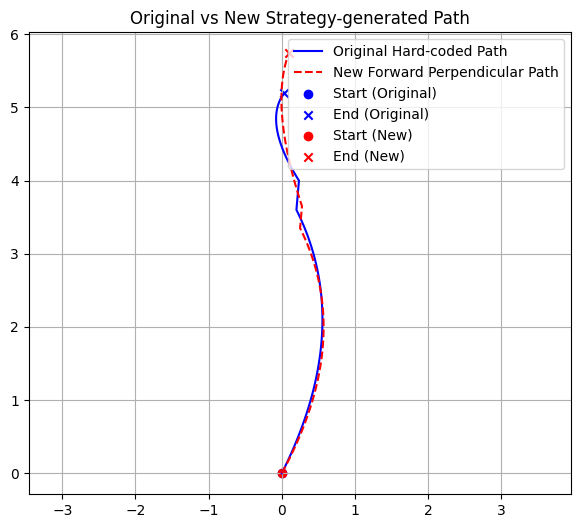

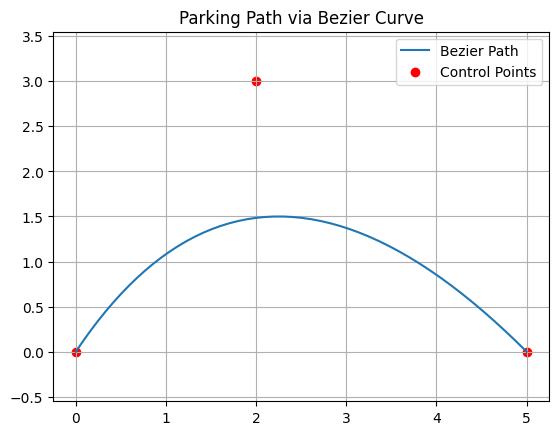

Step 1: Turn to 55.6°, Move 0.15m
Step 2: Turn to 54.2°, Move 0.14m
Step 3: Turn to 52.7°, Move 0.14m
Step 4: Turn to 51.1°, Move 0.13m
Step 5: Turn to 49.5°, Move 0.13m


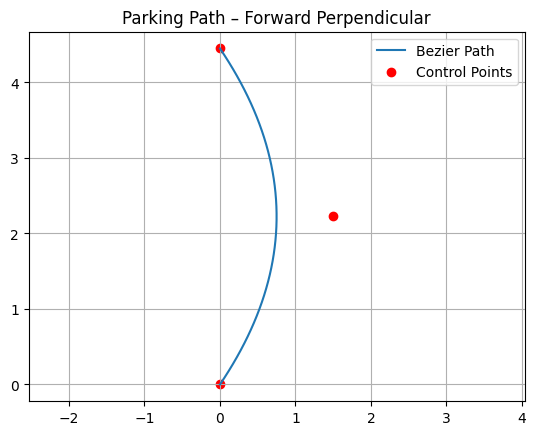

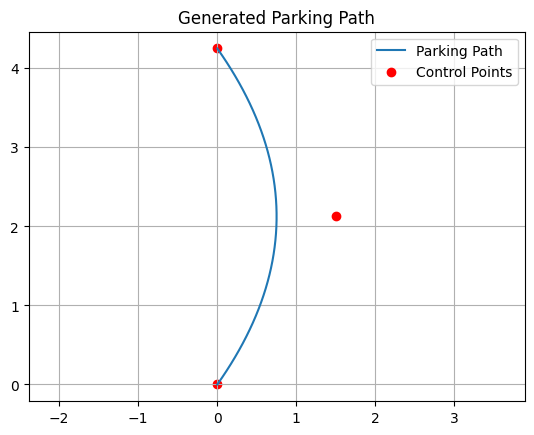

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)


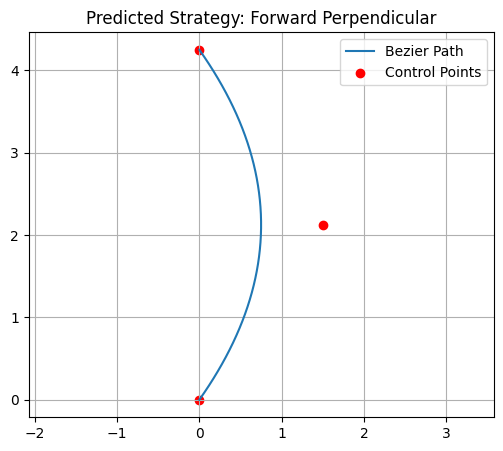

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)
✅ GIF saved as: parking_animation.gif


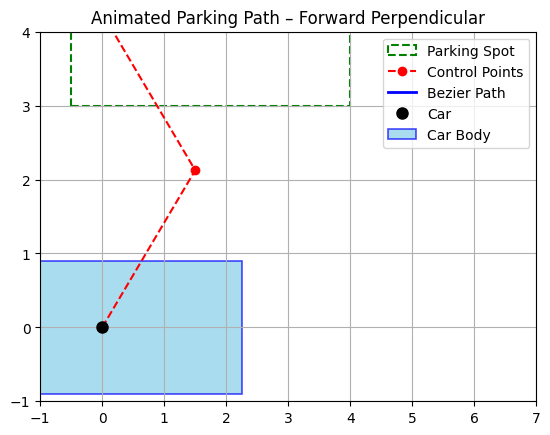